In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(title, image, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2 or image.shape[2] == 1:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# Load your puzzle image
image_path = "images/pieces.jpg"  # Change this to your image
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

display_image("1. Original Image", original_image)
display_image("2. Grayscale Image", gray_image)

print("✅ Images loaded successfully")
print(f"📏 Image size: {gray_image.shape[1]} x {gray_image.shape[0]} pixels")

In [2]:
print("🔧 STEP 1: Prepare image for edge detection")
print("Noise reduction is crucial for good edge detection")

# Apply Gaussian blur to reduce noise
# Why? Canny is sensitive to noise, blur smooths out small variations
blur_kernel_size = 5  # Try: 3, 5, 7 (must be odd)
blurred = cv2.GaussianBlur(gray_image, (blur_kernel_size, blur_kernel_size), 0)

display_image("3. After Gaussian Blur (noise reduction)", blurred)

# Show the difference (noise that was removed)
noise = cv2.subtract(gray_image, blurred)
display_image("3b. Noise that was removed", noise)

print(f"💡 Gaussian blur with kernel size {blur_kernel_size}x{blur_kernel_size}")
print("   - Removes small variations that would create false edges")
print("   - Larger kernel = more smoothing, fewer edges")
print("   - Smaller kernel = less smoothing, more edges")

Reading image from path: images/test_images/pieces.jpg


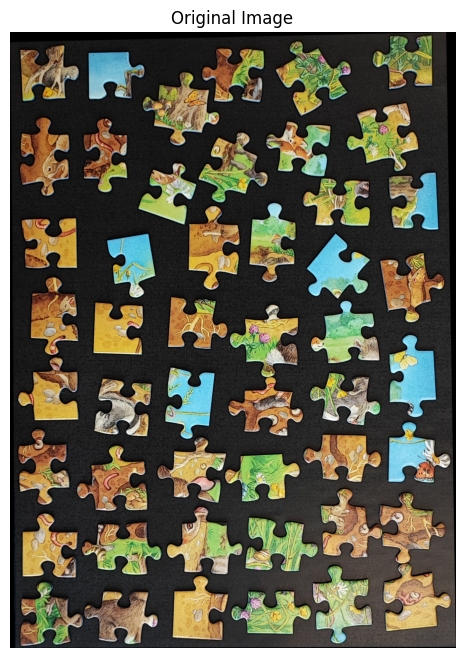

In [3]:
print("   - Larger kernel = more smoothing, fewer edges")
print("   - Smaller kernel = less smoothing, more edges")

# ========================================
# CELL 3: Apply Canny Edge Detection
# ========================================
print("🎯 STEP 2: Apply Canny Edge Detection")
print("Canny finds where brightness changes rapidly (edges)")

# Canny edge detection parameters
low_threshold = 50   # Try: 30, 50, 70
high_threshold = 150 # Try: 100, 150, 200

edges = cv2.Canny(blurred, low_threshold, high_threshold)

display_image("4. Canny Edges (white lines on black background)", edges)

print(f"🔍 Canny parameters: low={low_threshold}, high={high_threshold}")
print("   - Low threshold: detects weak edges")
print("   - High threshold: detects strong edges")
print("   - Edges between low and high are kept if connected to strong edges")
print("   - Result: White pixels = edges, Black pixels = non-edges")

# Show what each threshold detects individually
edges_low_only = cv2.Canny(blurred, low_threshold, low_threshold)
edges_high_only = cv2.Canny(blurred, high_threshold, high_threshold)

display_image("4b. Low threshold only (more sensitive)", edges_low_only)
display_image("4c. High threshold only (less sensitive)", edges_high_only)

Converting to grayscale


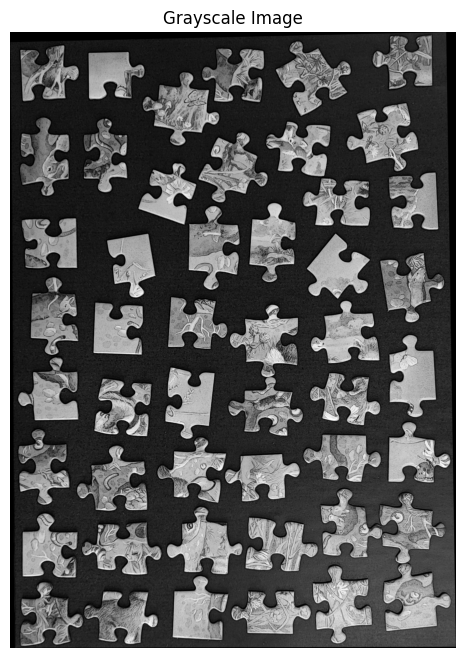

In [4]:
print("❌ PROBLEM: Canny gives us thin lines, not filled regions")
print("We need to transform these thin edge lines into solid puzzle piece masks")

# Count edge pixels vs total pixels
edge_pixels = np.count_nonzero(edges)
total_pixels = edges.shape[0] * edges.shape[1]
edge_percentage = (edge_pixels / total_pixels) * 100

print(f"📊 Edge statistics:")
print(f"   - Edge pixels: {edge_pixels:,}")
print(f"   - Total pixels: {total_pixels:,}")
print(f"   - Edge coverage: {edge_percentage:.2f}%")
print()
print("💡 We need to transform these thin lines into solid filled shapes!")

In [5]:
print("🔧 TRANSFORMATION 1: Thicken the edges")
print("Why? Thin lines disappear during morphological operations")

# Create a small kernel for dilation
edge_kernel_size = 3  # Try: 3, 5, 7
edge_kernel = np.ones((edge_kernel_size, edge_kernel_size), np.uint8)

# Dilate (thicken) the edges
iterations = 2  # Try: 1, 2, 3
thick_edges = cv2.dilate(edges, edge_kernel, iterations=iterations)

display_image("5. Thickened Edges", thick_edges)

# Show the difference
thickening_added = cv2.subtract(thick_edges, edges)
display_image("5b. Pixels added by thickening", thickening_added)

print(f"🔍 Dilation parameters:")
print(f"   - Kernel size: {edge_kernel_size}x{edge_kernel_size}")
print(f"   - Iterations: {iterations}")
print("   - Effect: Makes edge lines thicker and more connected")
print("   - More iterations = thicker edges = more connections")

=== METHOD 1: Adaptive Thresholding ===
This method handles uneven lighting automatically


In [6]:
adaptive_binary = cv2.adaptiveThreshold(
    gray_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Use Gaussian-weighted sum
    cv2.THRESH_BINARY,
    blockSize=21,  # Size of neighborhood area (try 11, 15, 21, 31)
    C=10  # Constant subtracted from the mean (try 5, 10, 15, 20)
)

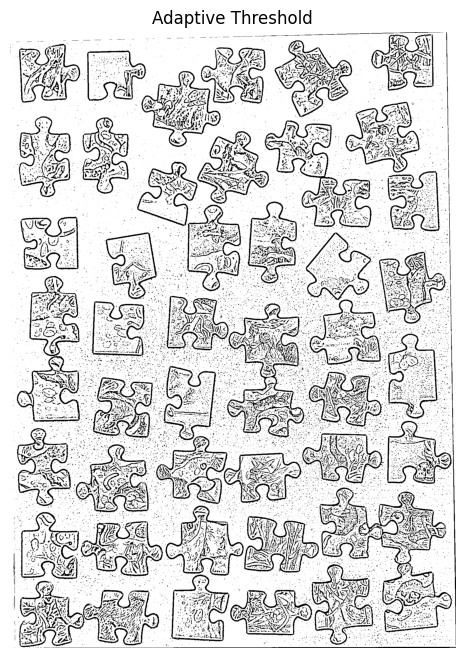

In [7]:
print("🔧 TRANSFORMATION 2: Close gaps between edge segments")
print("Why? Puzzle piece edges often have small gaps that need to be closed")

# Create kernel for closing gaps
close_kernel_size = 5  # Try: 3, 5, 7, 9
close_kernel = np.ones((close_kernel_size, close_kernel_size), np.uint8)

# Apply morphological closing (dilation followed by erosion)
close_iterations = 3  # Try: 1, 2, 3, 4, 5
closed_edges = cv2.morphologyEx(thick_edges, cv2.MORPH_CLOSE, close_kernel, iterations=close_iterations)

display_image("6. Closed Edges (gaps filled)", closed_edges)

# Show what gaps were filled
gaps_filled = cv2.subtract(closed_edges, thick_edges)
display_image("6b. Gaps that were filled", gaps_filled)

print(f"🔍 Morphological closing parameters:")
print(f"   - Kernel size: {close_kernel_size}x{close_kernel_size}")
print(f"   - Iterations: {close_iterations}")
print("   - Effect: Fills small gaps between edge segments")
print("   - Creates more complete outlines of puzzle pieces")

# Use Method A for the rest
filled_regions = filled_mask

In [8]:
print("=== METHOD 2: Background Subtraction ===")
print("Uncomment this cell if Method 1 doesn't work well")

=== METHOD 2: Background Subtraction ===
Uncomment this cell if Method 1 doesn't work well


In [9]:
print("=== METHOD 3: Illumination Correction ===")
print("Uncomment this cell if other methods don't work well")

=== METHOD 3: Illumination Correction ===
Uncomment this cell if other methods don't work well


Applying morphological operations to clean up the binary image


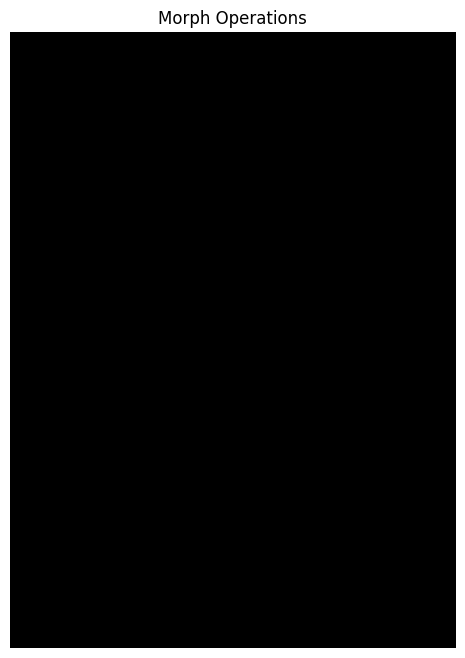

In [10]:
print("Applying morphological operations to clean up the binary image")
kernel = np.ones((12, 12), np.uint8)

# Close = filling the holes
morph_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
# Open = removing the noise
morph_image = cv2.morphologyEx(morph_image, cv2.MORPH_OPEN, kernel)
display_image("Morph Operations", morph_image)

Filling holes in puzzle pieces


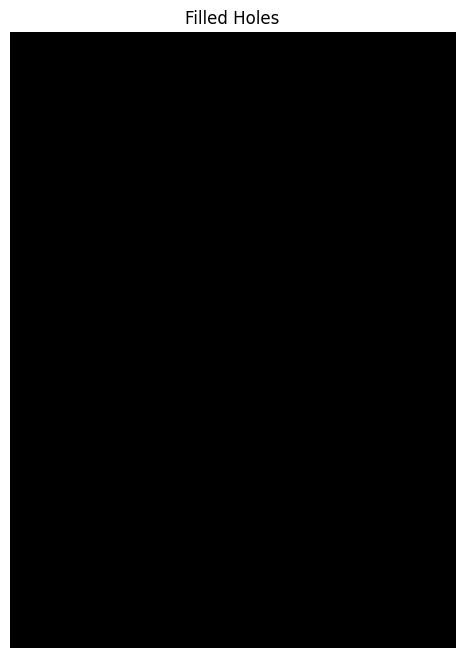

In [11]:
print("Filling holes in puzzle pieces")
contours_fill, _ = cv2.findContours(morph_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours_fill:
    cv2.drawContours(morph_image, [cnt], 0, 255, -1)
display_image("Filled Holes", morph_image)

In [12]:
contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"Found {len(contours)} potential puzzle pieces")

print("Filtering contours by size")
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
if len(contours) > 1:
    reference_area = cv2.contourArea(contours[1])
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > reference_area / 3]
print(f"After filtering: {len(contours)} puzzle pieces")

Found 1 potential puzzle pieces
Filtering contours by size
After filtering: 1 puzzle pieces


Drawing contours on the original image


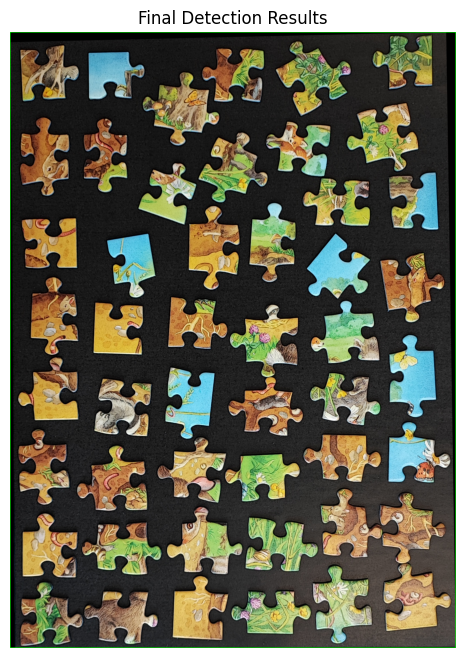

In [13]:
print("Drawing contours on the original image")
contour_image = original_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
display_image("Final Detection Results", contour_image)

In [14]:
output_folder_pieces = "images/bg/extracted_pieces"
os.makedirs(output_folder_pieces, exist_ok=True)

output_folder_contours = "images/bg/extracted_contours"
os.makedirs(output_folder_contours, exist_ok=True)

output_corner_folder = "images/bg/extracted_corners"
os.makedirs(output_corner_folder, exist_ok=True)

output_plots_folder = "images/bg/corner_plots"
os.makedirs(output_plots_folder, exist_ok=True)

print("Output directories created successfully")

Output directories created successfully


In [15]:
piece_images = []
for i, contour in enumerate(contours):
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], 0, 255, -1)

    piece = np.zeros_like(original_image)
    piece[mask == 255] = original_image[mask == 255]

    x, y, w, h = cv2.boundingRect(contour)
    cropped_piece = piece[y:y + h, x:x + w]
    piece_images.append(cropped_piece)

    piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
    cv2.imwrite(piece_path, cropped_piece)

    # Save piece with contour
    contour_piece = cropped_piece.copy()
    mask_cropped = mask[y:y + h, x:x + w]
    cv2.drawContours(contour_piece, [contour - [x, y]], 0, (255, 0, 255), 1, cv2.LINE_8)
    contour_path = os.path.join(output_folder_contours, f"contour_{i + 1}.png")
    cv2.imwrite(contour_path, contour_piece)

print(f"Extracted and saved {len(contours)} puzzle pieces")

Extracted and saved 1 puzzle pieces


In [16]:
print("=== PARAMETER TUNING GUIDE ===")
print("If the results are not satisfactory, try adjusting these parameters:")
print("")
print("For Adaptive Thresholding (Method 1):")
print("- blockSize: Try 11, 15, 21, 31 (must be odd)")
print("- C: Try 5, 10, 15, 20")
print("")
print("For Background Subtraction (Method 2):")
print("- kernel size: Try (30,30), (40,40), (60,60)")
print("- threshold value: Try 20, 30, 40")
print("")
print("For Illumination Correction (Method 3):")
print("- kernel_size: Try 30, 40, 60")
print("")
print("Re-run the cells with different parameters to optimize results!")

=== PARAMETER TUNING GUIDE ===
If the results are not satisfactory, try adjusting these parameters:

For Adaptive Thresholding (Method 1):
- blockSize: Try 11, 15, 21, 31 (must be odd)
- C: Try 5, 10, 15, 20

For Background Subtraction (Method 2):
- kernel size: Try (30,30), (40,40), (60,60)
- threshold value: Try 20, 30, 40

For Illumination Correction (Method 3):
- kernel_size: Try 30, 40, 60

Re-run the cells with different parameters to optimize results!


In [17]:
# Cell 15: Quick Parameter Test Function
def test_adaptive_parameters(gray_img, block_sizes=[11, 21, 31], c_values=[5, 10, 15]):
    """Test different parameter combinations for adaptive thresholding"""
    fig, axes = plt.subplots(len(block_sizes), len(c_values), figsize=(15, 12))

    for i, block_size in enumerate(block_sizes):
        for j, c_val in enumerate(c_values):
            adaptive = cv2.adaptiveThreshold(
                gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY, block_size, c_val
            )

            if len(block_sizes) == 1:
                ax = axes[j]
            elif len(c_values) == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]

            ax.imshow(adaptive, cmap='gray')
            ax.set_title(f'Block={block_size}, C={c_val}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
selected_image_index = 0  # Change this to analyze different pieces
if len(contours) > selected_image_index:
    print(f"Ready to analyze piece {selected_image_index + 1}")
    print("You can now continue with your corner detection code...")
else:
    print("No pieces detected. Try adjusting the parameters above.")

Ready to analyze piece 1
You can now continue with your corner detection code...
